In [1]:
import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
obj_dataset = dataset.replay_mapping_from_cache(5000)

Loading objects from .data/: 100%|██████████| 5000/5000 [02:06<00:00, 39.52it/s]


In [3]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
4304,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4305,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4306,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4307,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [ ]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

In [5]:
input = input_data
output = output_data

In [6]:
input[0:500]

x         y  visible  is_slider  is_spinner
chunk frame                                                    
0     0     -0.355469 -0.500000      0.0        1.0         0.0
      1     -0.355469 -0.500000      1.0        1.0         0.0
      2     -0.355469 -0.500000      1.0        1.0         0.0
      3     -0.355469 -0.500000      1.0        1.0         0.0
      4     -0.355469 -0.500000      1.0        1.0         0.0
...               ...       ...      ...        ...         ...
      495    0.171875 -0.005208      1.0        1.0         0.0
      496    0.195312  0.033854      1.0        1.0         0.0
      497    0.207031  0.083333      1.0        1.0         0.0
      498    0.201172  0.135417      1.0        1.0         0.0
      499    0.177734  0.179688      1.0        1.0         0.0

[500 rows x 5 columns]

In [7]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(16274, 2048, 5)

In [8]:
# ys = ys[0:xs.shape[0]]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 
# x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))
# 
# train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
# 
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# MODEL DEFINITIONS

class OsuReplayRNN:
    def __init__(self, input_data, output_data, test_size=0.2, batch_size=BATCH_SIZE, device=None, noise_std=0.0):  # Set to 0.0 to disable
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        
        # Handle input/output data inconsistency by taking minimum
        min_samples = min(input_data.shape[0], output_data.shape[0])
        input_data = input_data[:min_samples]
        output_data = output_data[:min_samples]
        
        # Train/test split
        x_train, x_test, y_train, y_test = train_test_split(
            input_data, output_data, test_size=test_size, random_state=42
        )
        
        # Create DataLoaders
        train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
        test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        input_size = input_data.shape[2]
        output_size = output_data.shape[2]
        
        self.model = self._create_model(input_size, output_size, noise_std)
        self.model.to(self.device)
        
        # Initialize optimizer and loss
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=0.01)
        self.criterion = nn.SmoothL1Loss()
        
        # Training history
        self.train_losses = []
        self.test_losses = []
        
        print(f"RNN Model initialized on {self.device} (noise_std={noise_std})")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}")
    
    def _create_model(self, input_size, output_size, noise_std):
        class OsuModel(nn.Module):
            def __init__(self, input_size, output_size, noise_std=0.0):
                super(OsuModel, self).__init__()
                
                self.lstm = nn.LSTM(input_size, 64, batch_first=True)
                self.dense1 = nn.Linear(64, 64)
                self.noise_std = noise_std
                self.dense2 = nn.Linear(64, 16)
                self.position = nn.Linear(16, output_size)
                
            def forward(self, x):
                lstm_out, _ = self.lstm(x)
                
                pos = self.dense1(lstm_out)
                
                # Configurable gaussian noise (only applied during training)
                if self.training and self.noise_std > 0:
                    noise = torch.randn_like(pos) * self.noise_std
                    pos = pos + noise
                
                pos = self.dense2(pos)
                pos = self.position(pos)
                
                return pos
        
        return OsuModel(input_size, output_size, noise_std)
    
    def train(self, epochs: int):
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            epoch_train_loss = 0
            
            for batch_x, batch_y in tqdm.tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs} (Train)'):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                
                epoch_train_loss += loss.item()
            
            # Validation phase
            self.model.eval()
            epoch_test_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in self.test_loader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)
                    
                    outputs = self.model(batch_x)
                    loss = self.criterion(outputs, batch_y)
                    epoch_test_loss += loss.item()
            
            # Calculate average losses
            avg_train_loss = epoch_train_loss / len(self.train_loader)
            avg_test_loss = epoch_test_loss / len(self.test_loader)
            
            self.train_losses.append(avg_train_loss)
            self.test_losses.append(avg_test_loss)
            
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('RNN Training Progress')
        plt.legend()
        plt.show()
    
    def save(self, path=None):
        if path is None:
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            path = f'.trained/rnn_{timestamp}.pt'
        
        if not os.path.exists('.trained'):
            os.makedirs('.trained')
            
        torch.save(self.model.state_dict(), path)
        torch.save(self.model.state_dict(), '.trained/rnn_most_recent.pt')
        print(f"RNN model saved to {path}")
    
    def generate(self, beatmap_data):
        self.model.eval()
        with torch.no_grad():
            beatmap_tensor = torch.FloatTensor(beatmap_data).to(self.device)
            return self.model(beatmap_tensor).cpu().numpy()


In [11]:

class OsuReplayGAN:
    def __init__(self, input_data, output_data, test_size=0.2, batch_size=BATCH_SIZE, device=None, noise_dim=0): 
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.noise_dim = noise_dim
        
        # Handle input/output data inconsistency by taking minimum
        min_samples = min(input_data.shape[0], output_data.shape[0])
        input_data = input_data[:min_samples]
        output_data = output_data[:min_samples]
        
        # Train/test split
        x_train, x_test, y_train, y_test = train_test_split(
            input_data, output_data, test_size=test_size, random_state=42
        )
        
        # Create DataLoaders
        train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
        test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize models
        input_size = input_data.shape[2]
        output_size = output_data.shape[2]
        
        self.generator = Generator(input_size, output_size, noise_dim)
        self.discriminator = Discriminator(input_size, output_size)
        
        self.generator.to(self.device)
        self.discriminator.to(self.device)
        
        # Initialize optimizers and losses
        self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self.adversarial_loss = nn.BCELoss()
        self.reconstruction_loss = nn.MSELoss()
        
        # Training history
        self.gen_losses = []
        self.disc_losses = []
        
        print(f"GAN Models initialized on {self.device} (noise_dim={noise_dim})")
        print(f"Generator parameters: {sum(p.numel() for p in self.generator.parameters() if p.requires_grad)}")
        print(f"Discriminator parameters: {sum(p.numel() for p in self.discriminator.parameters() if p.requires_grad)}")
    
    def train(self, epochs: int, lambda_recon=10.0):
        for epoch in range(epochs):
            epoch_gen_loss = 0
            epoch_disc_loss = 0
            
            for batch_x, batch_y in tqdm.tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs} (GAN)'):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                batch_size = batch_x.size(0)
                
                # Real and fake labels
                real_labels = torch.ones(batch_size, 1, device=self.device)
                fake_labels = torch.zeros(batch_size, 1, device=self.device)
                
                # ---------------------
                #  Train Discriminator
                # ---------------------
                self.disc_optimizer.zero_grad()
                
                # Real data
                real_output = self.discriminator(batch_x, batch_y)
                real_loss = self.adversarial_loss(real_output, real_labels)
                
                # Fake data
                fake_positions = self.generator(batch_x)
                fake_output = self.discriminator(batch_x, fake_positions.detach())
                fake_loss = self.adversarial_loss(fake_output, fake_labels)
                
                # Total discriminator loss
                disc_loss = (real_loss + fake_loss) / 2
                disc_loss.backward()
                self.disc_optimizer.step()
                
                # -----------------
                #  Train Generator
                # -----------------
                self.gen_optimizer.zero_grad()
                
                # Generate fake positions
                fake_positions = self.generator(batch_x)
                
                # Adversarial loss (fool discriminator)
                fake_output = self.discriminator(batch_x, fake_positions)
                adv_loss = self.adversarial_loss(fake_output, real_labels)
                
                # Reconstruction loss (maintain beatmap correspondence)
                recon_loss = self.reconstruction_loss(fake_positions, batch_y)
                
                # Total generator loss
                gen_loss = adv_loss + lambda_recon * recon_loss
                gen_loss.backward()
                self.gen_optimizer.step()
                
                epoch_gen_loss += gen_loss.item()
                epoch_disc_loss += disc_loss.item()
            
            # Calculate average losses
            avg_gen_loss = epoch_gen_loss / len(self.train_loader)
            avg_disc_loss = epoch_disc_loss / len(self.train_loader)
            
            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            
            print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
    
    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(self.gen_losses, label='Generator')
        ax1.plot(self.disc_losses, label='Discriminator')
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.set_title("GAN Training Losses")
        ax1.legend()
        
        # Plot them separately for better visibility
        ax2.plot(self.gen_losses, label='Generator', color='blue')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(self.disc_losses, label='Discriminator', color='red')
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Generator Loss", color='blue')
        ax2_twin.set_ylabel("Discriminator Loss", color='red')
        ax2.set_title("GAN Losses (Separate Scales)")
        
        plt.tight_layout()
        plt.show()
    
    def save(self, path_prefix=None):
        if path_prefix is None:
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            path_prefix = f'.trained/gan_{timestamp}'
        
        if not os.path.exists('.trained'):
            os.makedirs('.trained')
            
        torch.save(self.generator.state_dict(), f'{path_prefix}_generator.pt')
        torch.save(self.discriminator.state_dict(), f'{path_prefix}_discriminator.pt')
        torch.save(self.generator.state_dict(), '.trained/gan_generator_most_recent.pt')
        torch.save(self.discriminator.state_dict(), '.trained/gan_discriminator_most_recent.pt')
        print(f"GAN models saved with prefix {path_prefix}")
    
    def generate(self, beatmap_data):
        self.generator.eval()
        with torch.no_grad():
            beatmap_tensor = torch.FloatTensor(beatmap_data).to(self.device)
            return self.generator(beatmap_tensor).cpu().numpy()


class Generator(nn.Module):
    def __init__(self, input_size, output_size, noise_dim=32):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        
        if noise_dim > 0:
            # LSTM for processing beatmap features + noise
            self.lstm = nn.LSTM(input_size + noise_dim, 128, num_layers=2, batch_first=True, dropout=0.2)
        else:
            # LSTM for processing beatmap features only (no noise)
            self.lstm = nn.LSTM(input_size, 128, num_layers=2, batch_first=True, dropout=0.2)
        
        # Dense layers for generating cursor positions
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, 32)
        self.position = nn.Linear(32, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, beatmap_features, noise=None):
        if self.noise_dim > 0:
            batch_size, seq_len, _ = beatmap_features.shape
            
            # Generate noise if not provided
            if noise is None:
                noise = torch.randn(batch_size, seq_len, self.noise_dim, device=beatmap_features.device)
            
            # Concatenate beatmap features with noise
            x = torch.cat([beatmap_features, noise], dim=-1)
        else:
            # No noise - use beatmap features directly
            x = beatmap_features
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Dense layers with dropout
        x = F.relu(self.dense1(lstm_out))
        x = self.dropout(x)
        x = F.relu(self.dense2(x))
        x = self.dropout(x)
        x = self.position(x)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        
        # Input: beatmap features + cursor positions
        combined_input_size = input_size + output_size
        
        # LSTM for processing sequences
        self.lstm = nn.LSTM(combined_input_size, 64, num_layers=2, batch_first=True, dropout=0.2)
        
        # Dense layers for classification
        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, 16)
        self.classifier = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, beatmap_features, cursor_positions):
        # Concatenate beatmap features with cursor positions
        x = torch.cat([beatmap_features, cursor_positions], dim=-1)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last output for classification
        x = lstm_out[:, -1, :]  # Use last timestep
        
        # Dense layers with dropout
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = F.relu(self.dense2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.classifier(x))
        
        return x

In [12]:
print("Creating RNN model...")
rnn = OsuReplayRNN(xs, ys, noise_std=0.05)

Creating RNN model...
RNN Model initialized on cuda (noise_std=0.05)
Model parameters: 23410


Epoch 1/150 (Train): 100%|██████████| 204/204 [00:03<00:00, 56.28it/s]


Epoch 1/150, Train Loss: 0.0063, Test Loss: 0.0025


Epoch 2/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.98it/s]


Epoch 2/150, Train Loss: 0.0024, Test Loss: 0.0021


Epoch 3/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.37it/s]


Epoch 3/150, Train Loss: 0.0021, Test Loss: 0.0021


Epoch 4/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.08it/s]


Epoch 4/150, Train Loss: 0.0020, Test Loss: 0.0020


Epoch 5/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.74it/s]


Epoch 5/150, Train Loss: 0.0020, Test Loss: 0.0019


Epoch 6/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.59it/s]


Epoch 6/150, Train Loss: 0.0019, Test Loss: 0.0019


Epoch 7/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.16it/s]


Epoch 7/150, Train Loss: 0.0019, Test Loss: 0.0019


Epoch 8/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.77it/s]


Epoch 8/150, Train Loss: 0.0019, Test Loss: 0.0018


Epoch 9/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.47it/s]


Epoch 9/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 10/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.62it/s]


Epoch 10/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 11/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.41it/s]


Epoch 11/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 12/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.64it/s]


Epoch 12/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 13/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.35it/s]


Epoch 13/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 14/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.92it/s]


Epoch 14/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 15/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.09it/s]


Epoch 15/150, Train Loss: 0.0018, Test Loss: 0.0018


Epoch 16/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.93it/s]


Epoch 16/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 17/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.27it/s]


Epoch 17/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 18/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.33it/s]


Epoch 18/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 19/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.42it/s]


Epoch 19/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 20/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.61it/s]


Epoch 20/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 21/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.10it/s]


Epoch 21/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 22/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.72it/s]


Epoch 22/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 23/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.80it/s]


Epoch 23/150, Train Loss: 0.0017, Test Loss: 0.0017


Epoch 24/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.16it/s]


Epoch 24/150, Train Loss: 0.0016, Test Loss: 0.0017


Epoch 25/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.88it/s]


Epoch 25/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 26/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.65it/s]


Epoch 26/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 27/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.48it/s]


Epoch 27/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 28/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.06it/s]


Epoch 28/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 29/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.57it/s]


Epoch 29/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 30/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.26it/s]


Epoch 30/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 31/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.64it/s]


Epoch 31/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 32/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.80it/s]


Epoch 32/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 33/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.71it/s]


Epoch 33/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 34/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.94it/s]


Epoch 34/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 35/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.39it/s]


Epoch 35/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 36/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.64it/s]


Epoch 36/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 37/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.61it/s]


Epoch 37/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 38/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.35it/s]


Epoch 38/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 39/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.64it/s]


Epoch 39/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 40/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.47it/s]


Epoch 40/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 41/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.65it/s]


Epoch 41/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 42/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.30it/s]


Epoch 42/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 43/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.29it/s]


Epoch 43/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 44/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.84it/s]


Epoch 44/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 45/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.17it/s]


Epoch 45/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 46/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.06it/s]


Epoch 46/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 47/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.32it/s]


Epoch 47/150, Train Loss: 0.0015, Test Loss: 0.0016


Epoch 48/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.43it/s]


Epoch 48/150, Train Loss: 0.0015, Test Loss: 0.0016


Epoch 49/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.63it/s]


Epoch 49/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 50/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.54it/s]


Epoch 50/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 51/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.56it/s]


Epoch 51/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 52/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.09it/s]


Epoch 52/150, Train Loss: 0.0015, Test Loss: 0.0016


Epoch 53/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.69it/s]


Epoch 53/150, Train Loss: 0.0015, Test Loss: 0.0016


Epoch 54/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.75it/s]


Epoch 54/150, Train Loss: 0.0015, Test Loss: 0.0016


Epoch 55/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.36it/s]


Epoch 55/150, Train Loss: 0.0016, Test Loss: 0.0016


Epoch 56/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.90it/s]


Epoch 56/150, Train Loss: 0.0016, Test Loss: 0.0015


Epoch 57/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.69it/s]


Epoch 57/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 58/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.83it/s]


Epoch 58/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 59/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.90it/s]


Epoch 59/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 60/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.23it/s]


Epoch 60/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 61/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.41it/s]


Epoch 61/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 62/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.99it/s]


Epoch 62/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 63/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.75it/s]


Epoch 63/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 64/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.65it/s]


Epoch 64/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 65/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.45it/s]


Epoch 65/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 66/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.01it/s]


Epoch 66/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 67/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.82it/s]


Epoch 67/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 68/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.45it/s]


Epoch 68/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 69/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.74it/s]


Epoch 69/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 70/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.52it/s]


Epoch 70/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 71/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.96it/s]


Epoch 71/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 72/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.85it/s]


Epoch 72/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 73/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.55it/s]


Epoch 73/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 74/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.68it/s]


Epoch 74/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 75/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.23it/s]


Epoch 75/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 76/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.54it/s]


Epoch 76/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 77/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.13it/s]


Epoch 77/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 78/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.00it/s]


Epoch 78/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 79/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.17it/s]


Epoch 79/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 80/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.81it/s]


Epoch 80/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 81/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.00it/s]


Epoch 81/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 82/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.91it/s]


Epoch 82/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 83/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.94it/s]


Epoch 83/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 84/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.38it/s]


Epoch 84/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 85/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.44it/s]


Epoch 85/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 86/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.64it/s]


Epoch 86/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 87/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.19it/s]


Epoch 87/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 88/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.61it/s]


Epoch 88/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 89/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.07it/s]


Epoch 89/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 90/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.71it/s]


Epoch 90/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 91/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.53it/s]


Epoch 91/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 92/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.25it/s]


Epoch 92/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 93/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.69it/s]


Epoch 93/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 94/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.29it/s]


Epoch 94/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 95/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.98it/s]


Epoch 95/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 96/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.20it/s]


Epoch 96/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 97/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.60it/s]


Epoch 97/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 98/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.73it/s]


Epoch 98/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 99/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.74it/s]


Epoch 99/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 100/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.82it/s]


Epoch 100/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 101/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.84it/s]


Epoch 101/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 102/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.56it/s]


Epoch 102/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 103/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.90it/s]


Epoch 103/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 104/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.87it/s]


Epoch 104/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 105/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.66it/s]


Epoch 105/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 106/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.04it/s]


Epoch 106/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 107/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.36it/s]


Epoch 107/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 108/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.91it/s]


Epoch 108/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 109/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.83it/s]


Epoch 109/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 110/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.35it/s]


Epoch 110/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 111/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.32it/s]


Epoch 111/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 112/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.94it/s]


Epoch 112/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 113/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.85it/s]


Epoch 113/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 114/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.56it/s]


Epoch 114/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 115/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.80it/s]


Epoch 115/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 116/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.94it/s]


Epoch 116/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 117/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.38it/s]


Epoch 117/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 118/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.06it/s]


Epoch 118/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 119/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.09it/s]


Epoch 119/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 120/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.94it/s]


Epoch 120/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 121/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 84.52it/s]


Epoch 121/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 122/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.21it/s]


Epoch 122/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 123/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.23it/s]


Epoch 123/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 124/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.32it/s]


Epoch 124/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 125/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.86it/s]


Epoch 125/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 126/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.50it/s]


Epoch 126/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 127/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.75it/s]


Epoch 127/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 128/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.21it/s]


Epoch 128/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 129/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.95it/s]


Epoch 129/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 130/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.64it/s]


Epoch 130/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 131/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.93it/s]


Epoch 131/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 132/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.67it/s]


Epoch 132/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 133/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.17it/s]


Epoch 133/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 134/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.44it/s]


Epoch 134/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 135/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.11it/s]


Epoch 135/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 136/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.69it/s]


Epoch 136/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 137/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.22it/s]


Epoch 137/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 138/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.08it/s]


Epoch 138/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 139/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.54it/s]


Epoch 139/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 140/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.98it/s]


Epoch 140/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 141/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.62it/s]


Epoch 141/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 142/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.39it/s]


Epoch 142/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 143/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 81.88it/s]


Epoch 143/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 144/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.02it/s]


Epoch 144/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 145/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.77it/s]


Epoch 145/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 146/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.16it/s]


Epoch 146/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 147/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.32it/s]


Epoch 147/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 148/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 82.21it/s]


Epoch 148/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 149/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.15it/s]


Epoch 149/150, Train Loss: 0.0015, Test Loss: 0.0015


Epoch 150/150 (Train): 100%|██████████| 204/204 [00:02<00:00, 83.02it/s]


Epoch 150/150, Train Loss: 0.0015, Test Loss: 0.0015


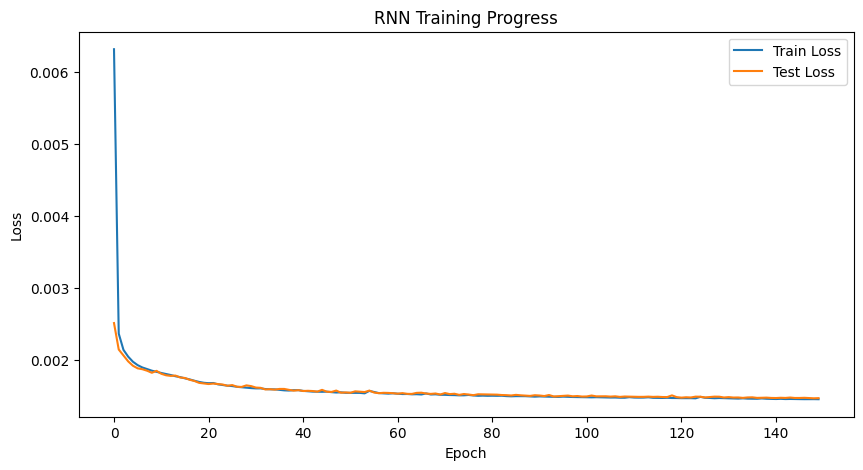

RNN model saved to .trained/rnn_2025-07-12_15-01-15.pt


In [13]:
RNN_EPOCHS = 150

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [17]:
print("Creating GAN model...")
gan = OsuReplayGAN(xs, ys, batch_size=BATCH_SIZE, noise_dim=4)

Creating GAN model...
GAN Models initialized on cuda (noise_dim=4)
Generator parameters: 213666
Discriminator parameters: 54593


Epoch 1/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.65it/s]


Epoch 1/15, Gen Loss: 0.9463, Disc Loss: 0.6934


Epoch 2/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.68it/s]


Epoch 2/15, Gen Loss: 0.7968, Disc Loss: 0.6931


Epoch 3/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.63it/s]


Epoch 3/15, Gen Loss: 0.7824, Disc Loss: 0.6932


Epoch 4/15 (GAN): 100%|██████████| 204/204 [00:27<00:00,  7.42it/s]


Epoch 4/15, Gen Loss: 0.7786, Disc Loss: 0.6932


Epoch 5/15 (GAN): 100%|██████████| 204/204 [00:27<00:00,  7.52it/s]


Epoch 5/15, Gen Loss: 0.7759, Disc Loss: 0.6931


Epoch 6/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.59it/s]


Epoch 6/15, Gen Loss: 0.7725, Disc Loss: 0.6931


Epoch 7/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.61it/s]


Epoch 7/15, Gen Loss: 0.7705, Disc Loss: 0.6934


Epoch 8/15 (GAN): 100%|██████████| 204/204 [00:27<00:00,  7.52it/s]


Epoch 8/15, Gen Loss: 0.7689, Disc Loss: 0.6932


Epoch 9/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.64it/s]


Epoch 9/15, Gen Loss: 0.7671, Disc Loss: 0.6931


Epoch 10/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.62it/s]


Epoch 10/15, Gen Loss: 0.7668, Disc Loss: 0.6931


Epoch 11/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.70it/s]


Epoch 11/15, Gen Loss: 0.7665, Disc Loss: 0.6932


Epoch 12/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.70it/s]


Epoch 12/15, Gen Loss: 0.7665, Disc Loss: 0.6931


Epoch 13/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.76it/s]


Epoch 13/15, Gen Loss: 0.7646, Disc Loss: 0.6932


Epoch 14/15 (GAN): 100%|██████████| 204/204 [00:26<00:00,  7.77it/s]


Epoch 14/15, Gen Loss: 0.7641, Disc Loss: 0.6932


Epoch 15/15 (GAN): 100%|██████████| 204/204 [00:25<00:00,  7.92it/s]


Epoch 15/15, Gen Loss: 0.7640, Disc Loss: 0.6933


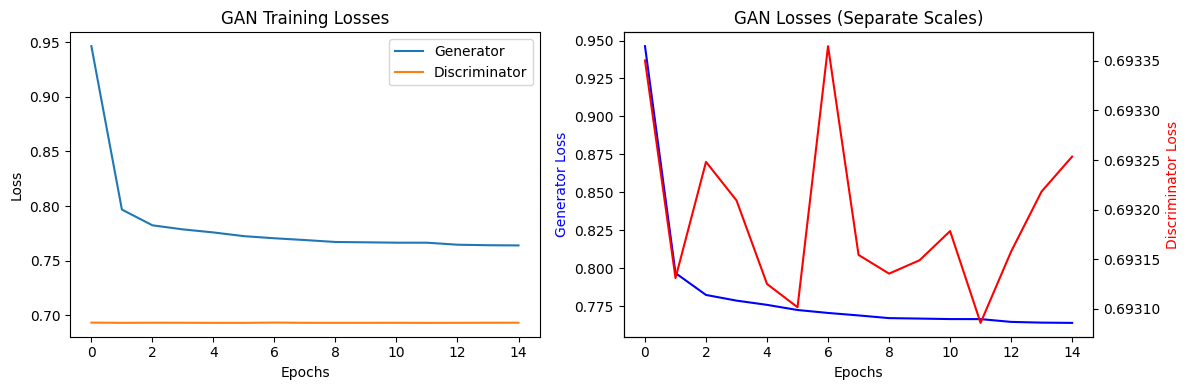

GAN models saved with prefix .trained/gan_2025-07-12_16-49-02


In [18]:
GAN_EPOCHS = 15

# Train the GAN
gan.train(epochs=GAN_EPOCHS, lambda_recon=10.0)
gan.plot_losses()
gan.save()

In [61]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'ghosts'
test_mods = ['ez']
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

Turning beatmaps into time series data:   0%|          | 0/1 [00:00<?, ?it/s]

(False, False, True, False)


Turning beatmaps into time series data: 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


In [63]:
with torch.no_grad():
    # Use generator for inference
    replay_data = gan.generate(data)
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

Generated replay data shape: (16384, 2)
Saved to .generated\ghosts.npy


In [64]:
replay_data

array([[-0.07173923, -0.01584955],
       [-0.13895378, -0.05127204],
       [-0.16021165, -0.06560034],
       ...,
       [ 0.00263351, -0.00058744],
       [ 0.00260476, -0.00050703],
       [ 0.00257602, -0.00050573]], shape=(16384, 2), dtype=float32)

In [65]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)